# Auto Process Pipeline for one of the subject (subject 10)

### Overview:
1. Identify and remove corrupted/bad channels
2. High Pass filter at 0.1 Hz to remove slow drift
3. Notch filter at 60 Hz to remove line noise
4. Laplacian Re-referencing

In [1]:
#New-re-framed work according to fieldtrip workflow
from scipy.io import loadmat
from scipy.signal import spectrogram
import pandas as pd
import numpy as np
import os, glob

from nltools import Brain_Data
from nltools.mask import create_sphere
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation

import matplotlib.pyplot as plt
import nibabel as nib
#%matplotlib inline
from sklearn.decomposition import FastICA
from nltools.stats import downsample
import seaborn as sns
import mne
from mne.viz import plot_raw
from copy import deepcopy
from mne.io.pick import pick_types, pick_channels

from mne.filter import resample,construct_iir_filter
from mne.baseline import rescale
from mne import make_fixed_length_events
from mne import Epochs

from nltools.prefs import MNI_Template
MNI_Template['resolution'] = '3mm'

from scipy.stats import gamma

import numpy.polynomial.polynomial as poly
from mne.time_frequency import psd_array_multitaper
from scipy.integrate import simps
import timeit
#from scipy.signal import welch
from scipy.stats import spearmanr
from scipy import signal

from nilearn.plotting import plot_glass_brain, plot_stat_map
import tables
from mne.time_frequency import tfr_array_morlet,psd_array_welch
import nltools as nlt
import random
import re

### Grand Section 1: Read in data

In [2]:
#Read in data

subject = 's10_2.EDF'
#Load the corresponding raw Ecog files
path = "F:/Summer2019/s10_scripts/"
raw = mne.io.read_raw_edf(path+subject, preload=True)
mne.set_log_level("WARNING")
#Cht the sEEG signal to the movie length 
trig_ix = np.where(np.array(raw.ch_names)=='DC1')[0][0]
print(trig_ix)
sfreq = raw.info['sfreq']
print("sfreq:",sfreq)
#Start & End
data, times = raw["DC1",:]
firstdiff = np.where(np.diff(data.T.ravel())>2)[0] 
print(firstdiff)

moviestart_diff = np.where(np.diff(firstdiff) > sfreq * 2717.80)[0]
print(moviestart_diff)
moviestart = firstdiff[moviestart_diff][0]
movieend = firstdiff[moviestart_diff+1][0]
print("start in secs:",moviestart/sfreq)
print("end in secs:",movieend/sfreq)
print('length of session:',movieend/sfreq-moviestart/sfreq)
raw_2 = raw.crop(tmin = moviestart / sfreq, tmax = movieend / sfreq) # Crop the times
del raw
ch_total_names = raw_2.info['ch_names']

Extracting EDF parameters from F:\Summer2019\s10_scripts\s10_2.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1418047  =      0.000 ...  2769.623 secs...
256
sfreq: 512.0
[   3686    3687   18211   18212 1409758 1409759]
[3]
start in secs: 35.5703125
end in secs: 2753.43359375
length of session: 2717.86328125


### Grand Section 2: Select channels

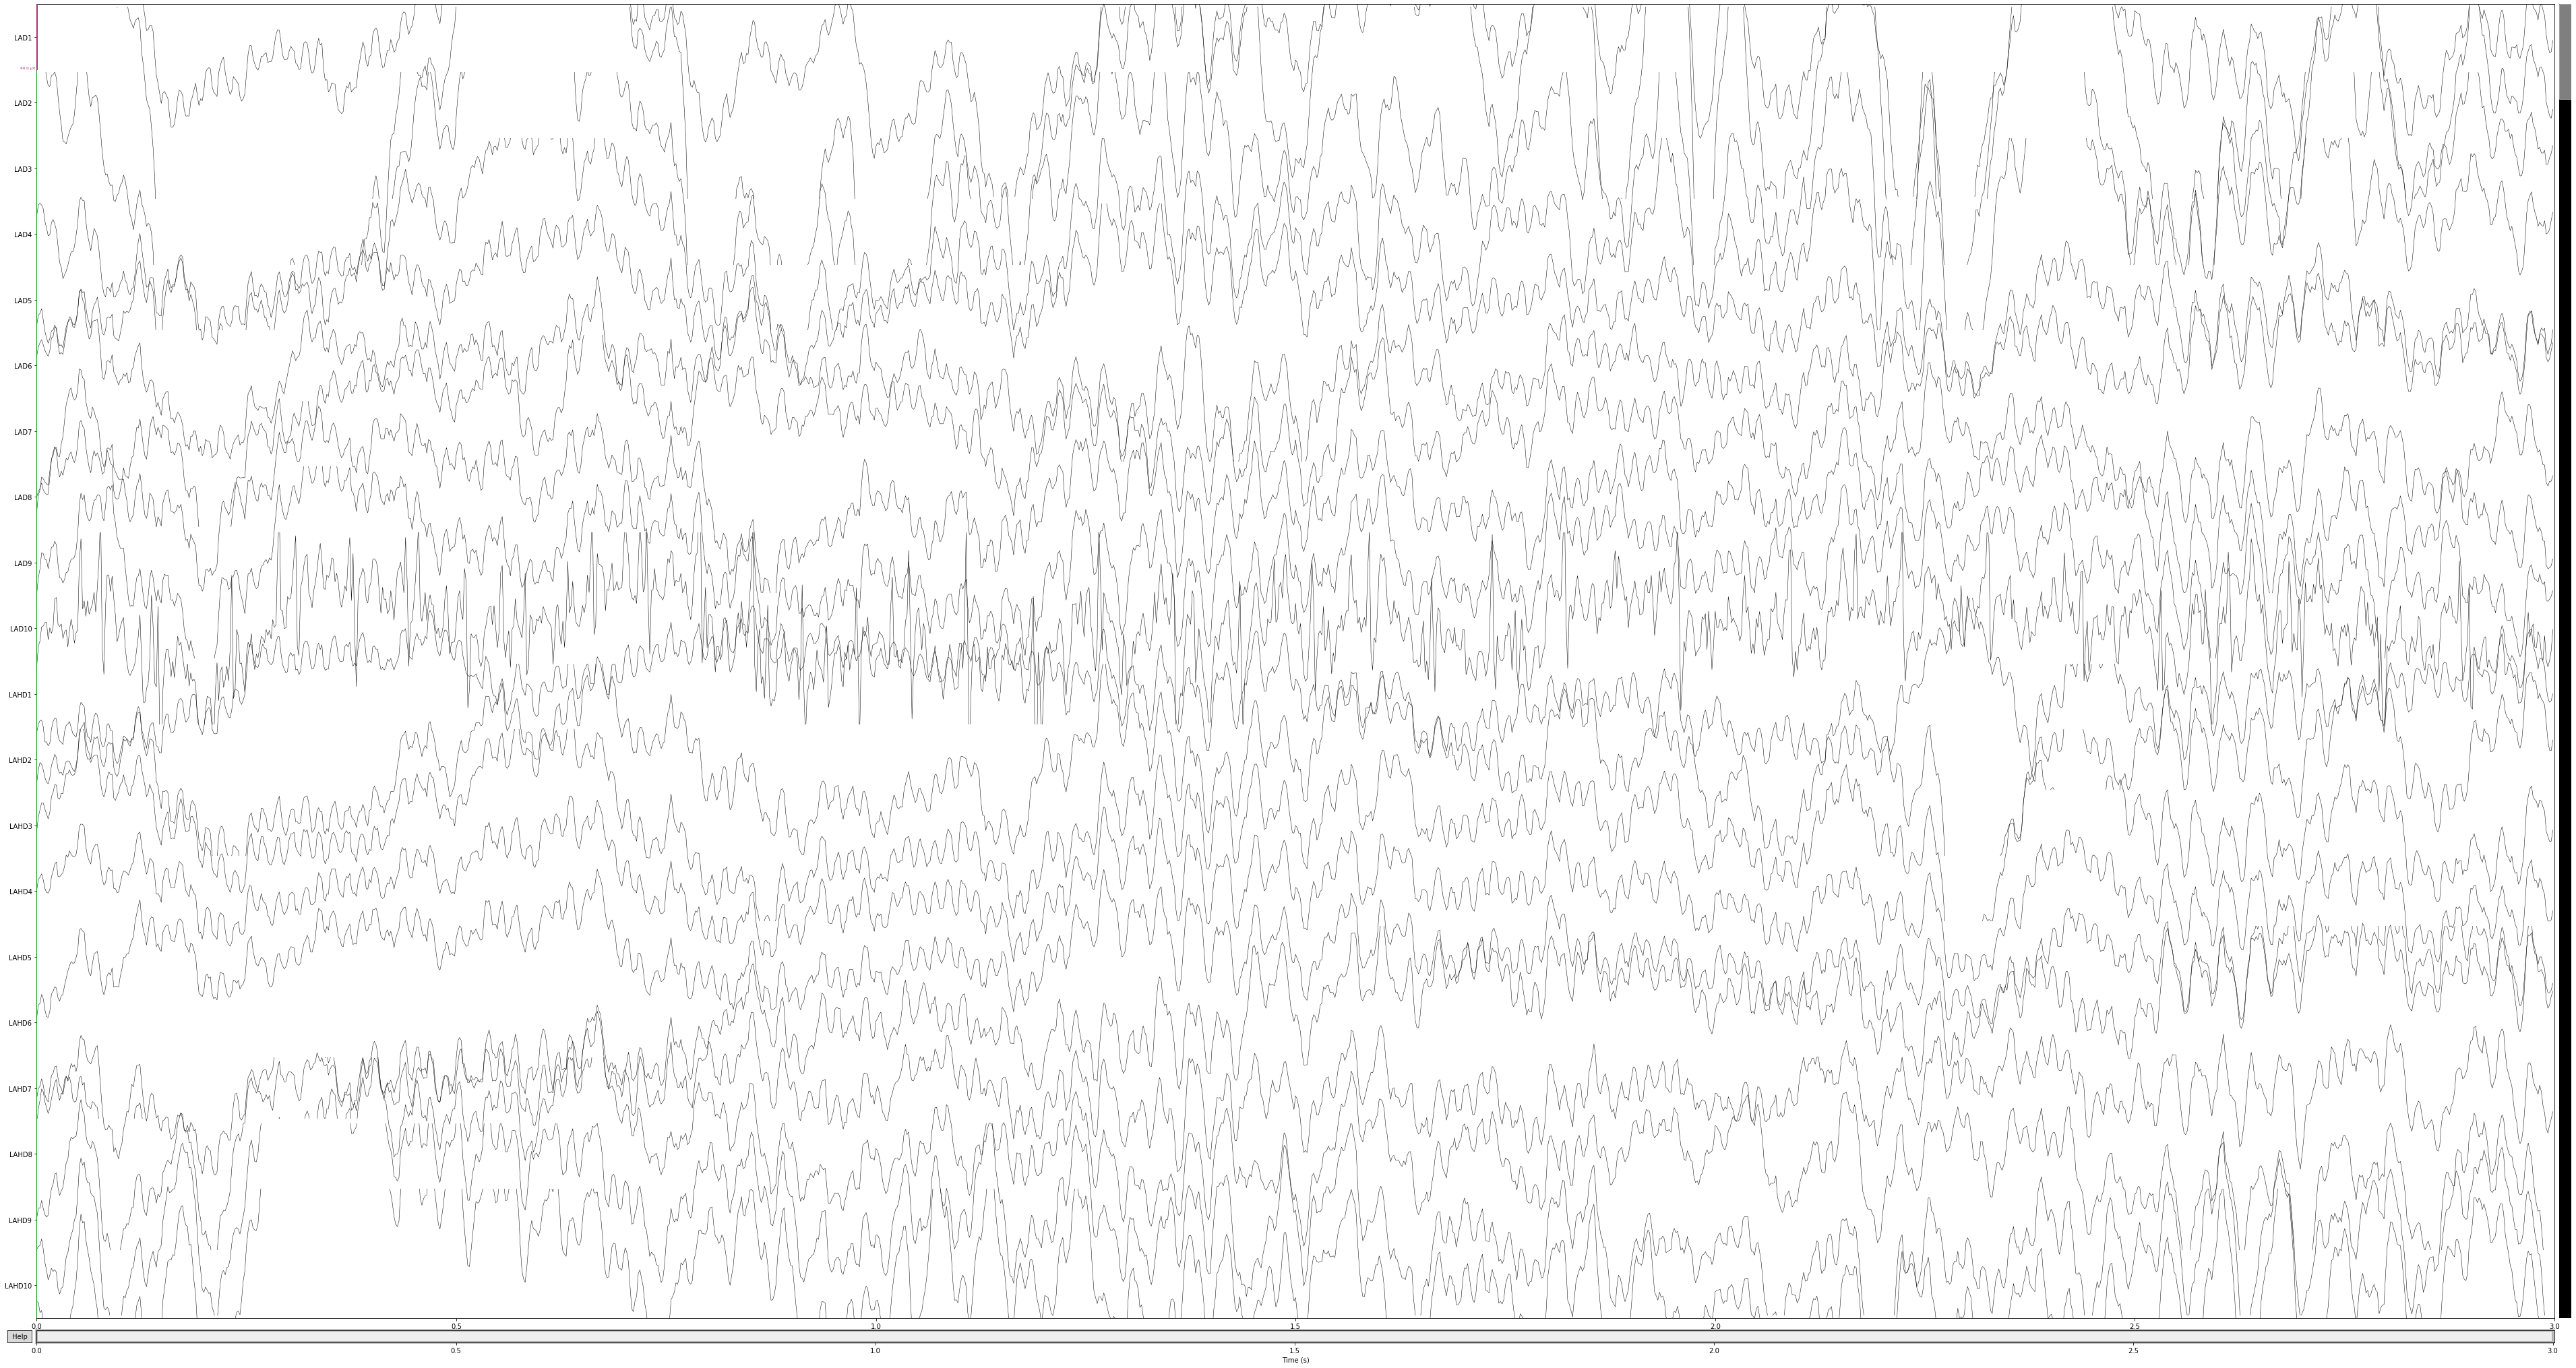

In [8]:
# An plot of all channels, find out which ones are bad/corrupted 

%matplotlib qt5
plot_raw(raw_3)

From the above channel plot we luckily did not find any seriously bad channels

In [3]:
# Remove uncessary reference channels

print(ch_total_names)
ch_idx_end = ch_total_names.index("C157")
print(ch_idx_end)

picks_1 = ch_total_names[0:ch_idx_end]
raw_2 = raw_2.pick(picks = picks_1)

['LAD1', 'LAD2', 'LAD3', 'LAD4', 'LAD5', 'LAD6', 'LAD7', 'LAD8', 'LAD9', 'LAD10', 'LAHD1', 'LAHD2', 'LAHD3', 'LAHD4', 'LAHD5', 'LAHD6', 'LAHD7', 'LAHD8', 'LAHD9', 'LAHD10', 'LPHD1', 'LPHD2', 'LPHD3', 'LPHD4', 'LPHD5', 'LPHD6', 'LPHD7', 'LPHD8', 'LPHD9', 'LPHD10', 'LOFCD1', 'LOFCD2', 'LOFCD3', 'LOFCD4', 'LOFCD5', 'LOFCD6', 'LOFCD7', 'LOFCD8', 'LOFCD9', 'LOFCD10', 'LACD1', 'LACD2', 'LACD3', 'LACD4', 'LACD5', 'LACD6', 'LACD7', 'LACD8', 'LACD9', 'LACD10', 'LFMD1', 'LFMD2', 'LFMD3', 'LFMD4', 'LFMD5', 'LFMD6', 'LFMD7', 'LFMD8', 'LFMD9', 'LFMD10', 'RAD1', 'RAD2', 'RAD3', 'RAD4', 'RAD5', 'RAD6', 'RAD7', 'RAD8', 'RAD9', 'RAD10', 'RAD11', 'RAD12', 'RAHD1', 'RAHD2', 'RAHD3', 'RAHD4', 'RAHD5', 'RAHD6', 'RAHD7', 'RAHD8', 'RAHD9', 'RAHD10', 'RAHD11', 'RAHD12', 'RAHD13', 'RAHD14', 'RAHD15', 'RAHD16', 'RPHD1', 'RPHD2', 'RPHD3', 'RPHD4', 'RPHD5', 'RPHD6', 'RPHD7', 'RPHD8', 'RPHD9', 'RPHD10', 'RPHD11', 'RPHD12', 'RPHD13', 'RPHD14', 'ROFCD1', 'ROFCD2', 'ROFCD3', 'ROFCD4', 'ROFCD5', 'ROFCD6', 'ROFCD7', 'R

In [6]:
# Remove Bad Channels
bad_channels = ['LACD5', 'LACD4', 'RAD6', 'LPHD5', 'LOFCD3', 'ROFCD1', 'RPHD14', 'LID9', 'LID7', 'LID6', 'RPHD13', 'RPHD9', 'ROFCD4', 'ROFCD5', 'LAHD5', 'LAD10', 'LAHD2']

s10_picks = s10auditory_names+s10_vmPFC

In [7]:
good_channels = [a for a in picks_1 if a not in bad_channels]
print(good_channels)

['LAD1', 'LAD2', 'LAD3', 'LAD4', 'LAD5', 'LAD6', 'LAD7', 'LAD8', 'LAD9', 'LAHD1', 'LAHD3', 'LAHD4', 'LAHD6', 'LAHD7', 'LAHD8', 'LAHD9', 'LAHD10', 'LPHD1', 'LPHD2', 'LPHD3', 'LPHD4', 'LPHD6', 'LPHD7', 'LPHD8', 'LPHD9', 'LPHD10', 'LOFCD1', 'LOFCD2', 'LOFCD4', 'LOFCD5', 'LOFCD6', 'LOFCD7', 'LOFCD8', 'LOFCD9', 'LOFCD10', 'LACD1', 'LACD2', 'LACD3', 'LACD6', 'LACD7', 'LACD8', 'LACD9', 'LACD10', 'LFMD1', 'LFMD2', 'LFMD3', 'LFMD4', 'LFMD5', 'LFMD6', 'LFMD7', 'LFMD8', 'LFMD9', 'LFMD10', 'RAD1', 'RAD2', 'RAD3', 'RAD4', 'RAD5', 'RAD7', 'RAD8', 'RAD9', 'RAD10', 'RAD11', 'RAD12', 'RAHD1', 'RAHD2', 'RAHD3', 'RAHD4', 'RAHD5', 'RAHD6', 'RAHD7', 'RAHD8', 'RAHD9', 'RAHD10', 'RAHD11', 'RAHD12', 'RAHD13', 'RAHD14', 'RAHD15', 'RAHD16', 'RPHD1', 'RPHD2', 'RPHD3', 'RPHD4', 'RPHD5', 'RPHD6', 'RPHD7', 'RPHD8', 'RPHD10', 'RPHD11', 'RPHD12', 'ROFCD2', 'ROFCD3', 'ROFCD6', 'ROFCD7', 'ROFCD8', 'ROFCD9', 'ROFCD10', 'RACD1', 'RACD2', 'RACD3', 'RACD4', 'RACD5', 'RACD6', 'RACD7', 'RACD8', 'RACD9', 'RACD10', 'RACD11', '

In [8]:
raw_2 = raw_2.pick(picks = good_channels)

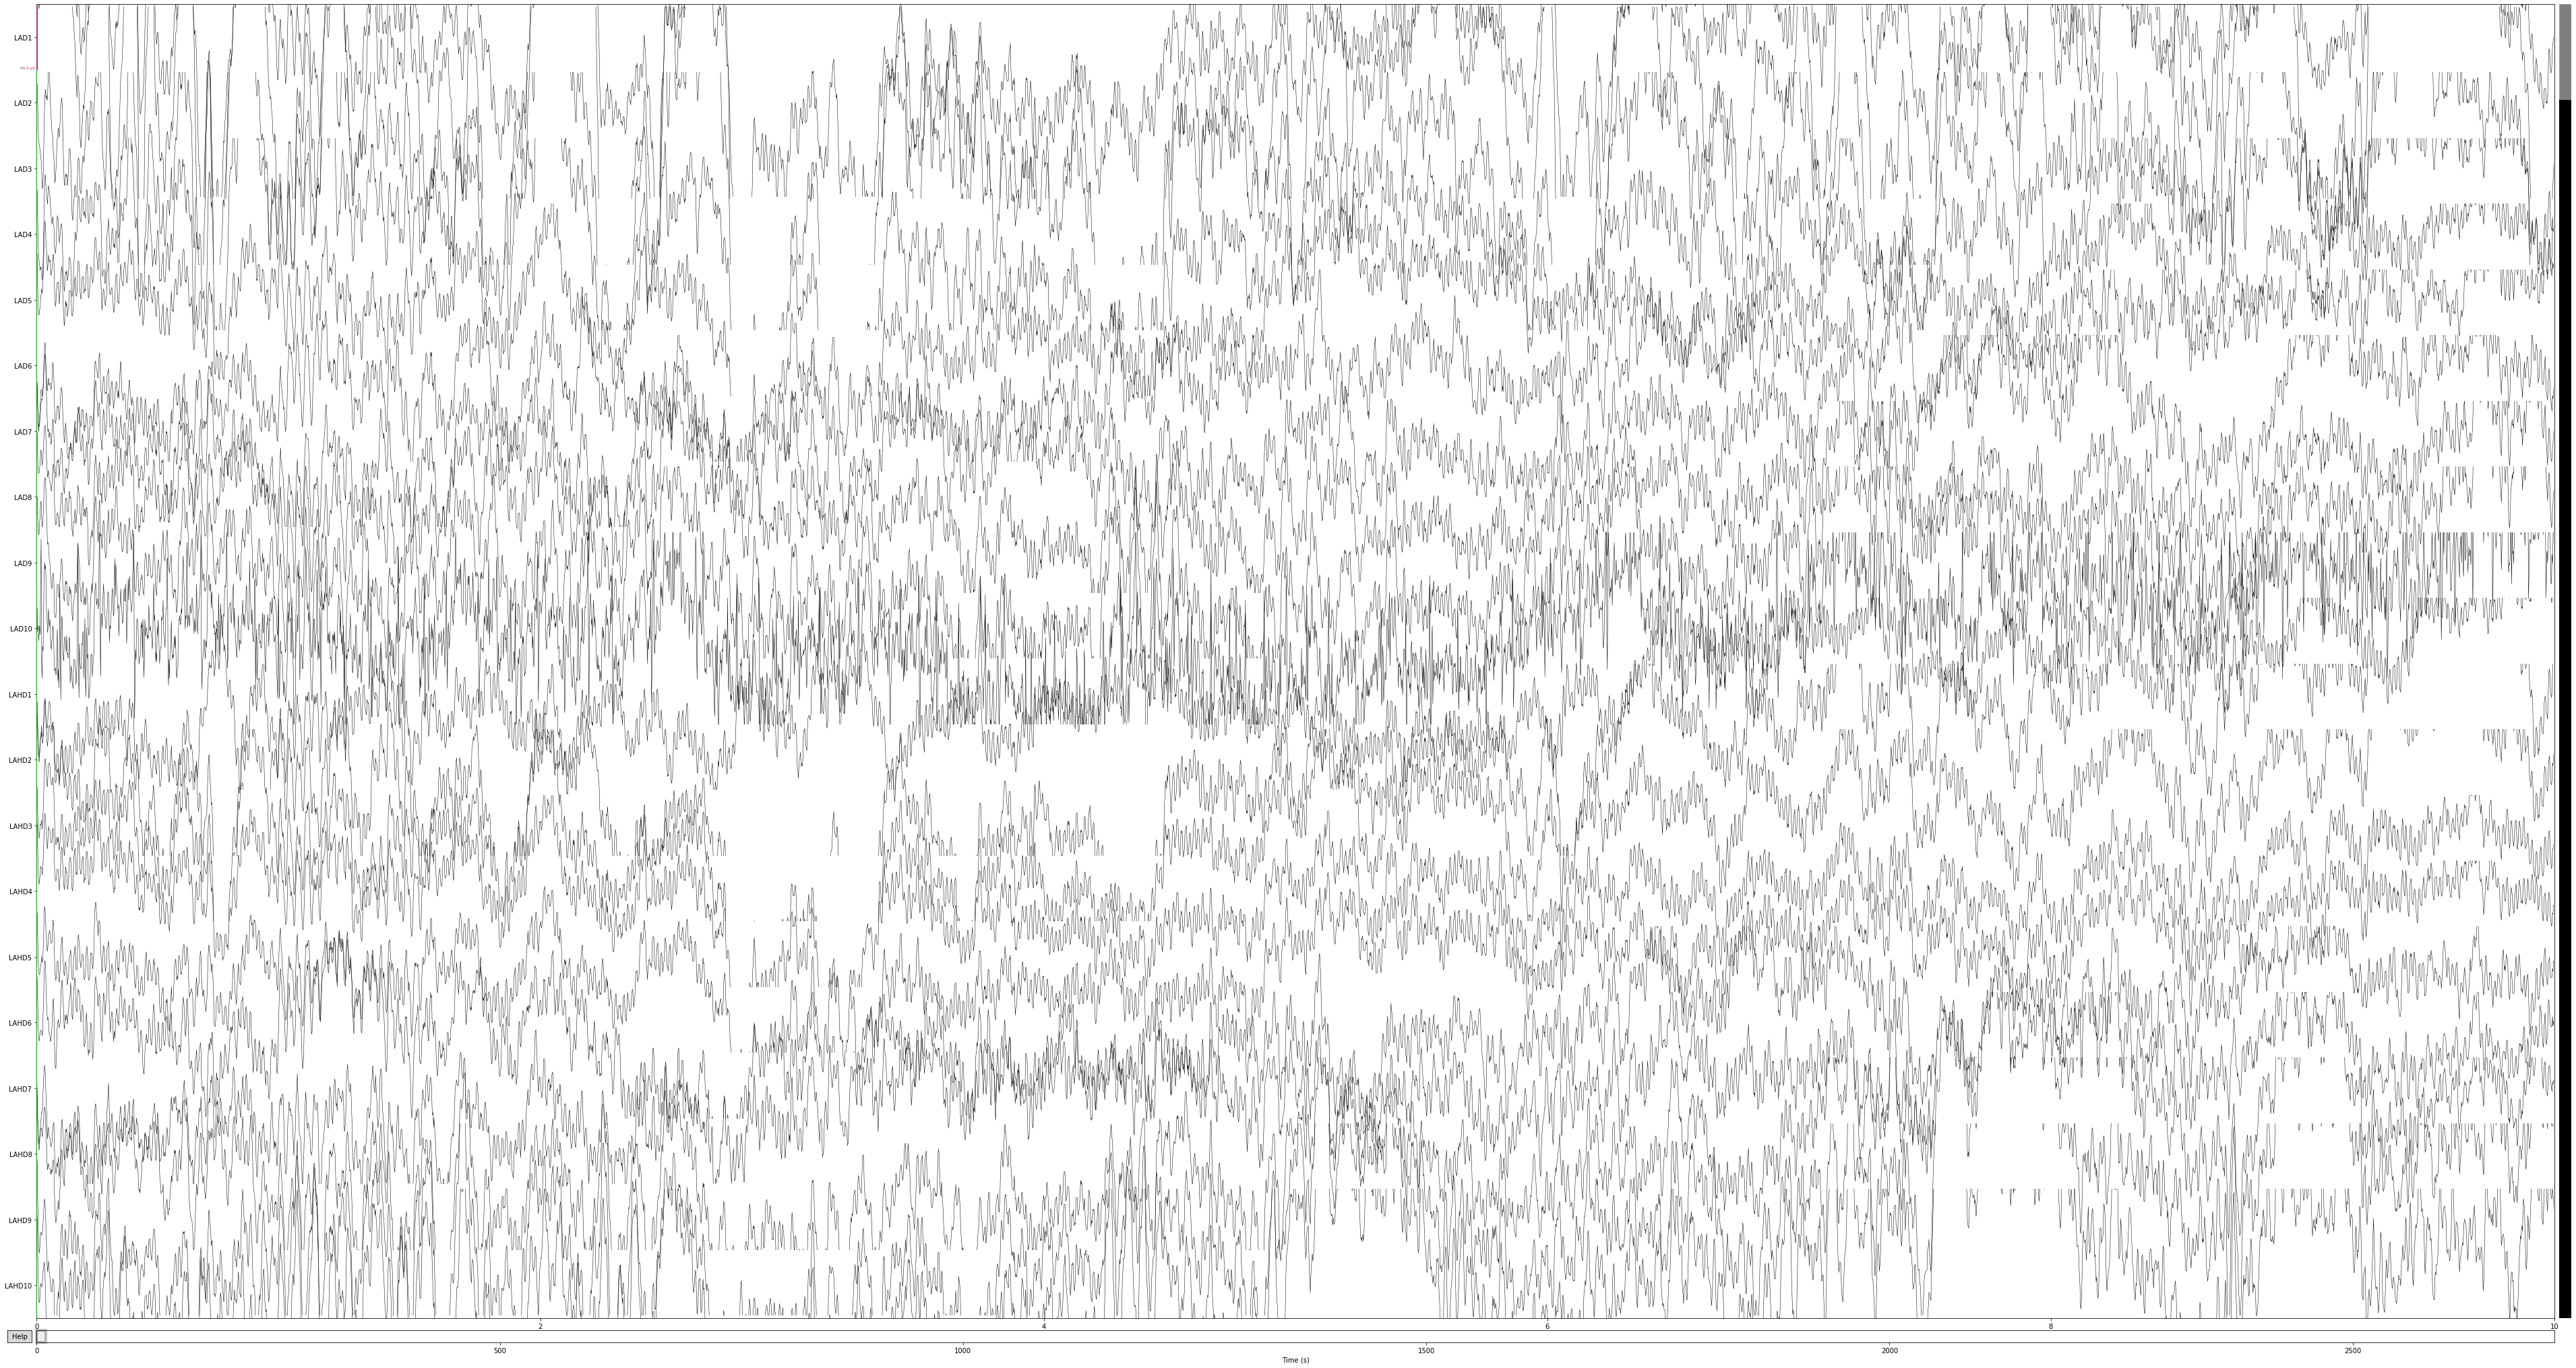

In [9]:
# Should not have any bad channels here
%matplotlib qt5
plot_raw(raw_2)

<ipython-input-12-c6200cf46453>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_2.plot_psd(area_mode='range', tmax=30.0, fmin = 0, fmax = 80, picks=s10_picks,xscale='log')


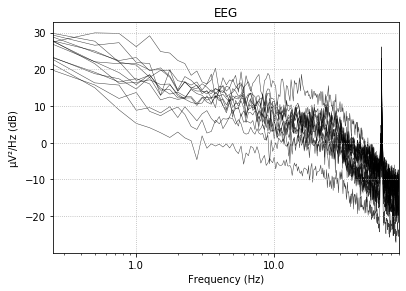

In [12]:
raw_2.plot_psd(area_mode='range', tmax=30.0, fmin = 0, fmax = 80, picks=s10_picks,xscale='log')

### Grand Section 3: Remove slow drift and notch filtering

In [9]:
# High Pass filtering at 0.1 Hz
raw_2.filter(l_freq = 0.1, h_freq = None, method = 'fir',fir_design = "firwin",filter_length = '200s')

<RawEDF | s10_2.EDF, 139 x 1391547 (2717.9 s), ~1.44 GB, data loaded>

In [8]:
# Notch filtering 60 Hz and harmonics
raw_2.notch_filter(np.arange(60, 241, 60), filter_length='auto',phase='zero')

<RawEDF  |  s10_2.EDF, n_channels x n_times : 151 x 1391547 (2717.9 sec), ~1.57 GB, data loaded>

### Grand Section 4: Laplacian Rereference

In [3]:
def apply_rereference(raw_3, align_hertz = 'Default', remove_mode = False, mode = "laplacian"):
    """
    Custom function to apply re-reference. Currently supports global mean averaging and laplacian
    mode == "mean" or "laplacian"
    """
    ch_total_names = raw_3.info['ch_names'] #Channel names
    annots = raw_3.annotations #Channel annotations, includes bad channels and bad time periods
    picks_bd = [pk_names for pk_names in ch_total_names if pk_names not in raw_3.info['bads']] # Bad channel names
    
    raw_4 = raw_3.copy() #Copy a new data
    raw_4 = raw_4.pick(picks = picks_bd) # the new data consists only channels that are NOT BAD 
    data_m1 = raw_4.get_data() #NP Array
    del raw_4
    ###############################Remove bad time periods####################################
    if remove_mode: #If we decide to remove bad time periods
        
        #Everything below tries to remove the bad time periods.
        
        original_time_stamps = np.zeros((len(annots),2))

        if align_hertz == 'Default':
            #Default is simply 1Hz
            for i in range(len(annots)):
                original_time_stamps[i,0] = annots[i]['onset']  - moviestart / sfreq
                original_time_stamps[i,1] = annots[i]['onset'] + annots[i]['duration'] - moviestart / sfreq 
        else:
            tr = int(1/align_hertz)

            for i in range(len(annots)):
                #print(annots[i]['onset'])
                #print('modulo', annots[i]['onset'] // 2)
                #print(annots[i]['duration'])
                #original_time_stamps[i,0] = annots[i]['onset']
                #original_time_stamps[i,1] = annots[i]['onset'] + annots[i]['duration']
                #print("annots:",annots[i]['onset'])
                #print("durat:",annots[i]['duration'] )
    #             original_time_stamps[i,0] = ((annots[i]['onset'] - moviestart / sfreq ) // tr) * tr
    #             print("time start:",original_time_stamps[i,0])
    #             durat = annots[i]['duration']
    #             original_time_stamps[i,1] = ((annots[i]['onset'] + durat - moviestart / sfreq) // tr) * tr + 1
    #             print("time start:",original_time_stamps[i,1])
                original_time_stamps[i,0] = np.floor((annots[i]['onset'] - moviestart / sfreq)/tr) * tr
                print("time start:",original_time_stamps[i,0])
                durat = annots[i]['duration']
                original_time_stamps[i,1] = np.ceil((annots[i]['onset'] + durat - moviestart / sfreq)/tr) *tr
                print("time start:",original_time_stamps[i,1])           

        print("Original shape of data matrix after removing bad channels:",data_m1.shape)
        del_lists = []

        for i in range(len(original_time_stamps)):
            del_lists = [*del_lists,*np.arange(int(original_time_stamps[i][0]*sfreq),int(original_time_stamps[i][1]*sfreq),1)]

        data_m1 = np.delete(data_m1,del_lists,1)
    
    print("np.delete data matrix size:",data_m1.shape)
    
    #Step 5
    electrode_names = raw_3.info['ch_names']
    # Find electrode canonical names
    electrode_dupl = list()
    for j in range(len(electrode_names)):
        sup = ''.join(i for i in electrode_names[j] if i.isalpha())
        electrode_dupl.append(sup)

    electrode_dupl = list(dict.fromkeys(electrode_dupl))
    print("Electrode canonical names:")

    print(electrode_dupl)
    
    new_data_m1 = data_m1.copy() # THis is the data for cleaned frame, will do re-referencing next
    
    ################################Referencing###########################################
    # Find all the electrode names
    if mode == "laplacian":
        for names in electrode_dupl:
            list_a = [a for a in picks_bd if names in a]
            both = set(list_a).intersection(picks_bd)
            indices_lists_data = np.sort([picks_bd.index(x) for x in both])
            data_slice = data_m1[indices_lists_data,:]
            elec_pos_num = []

            for ele in list_a:
                match = re.match(r"([a-z]+)([0-9]+)", ele, re.I)
                if match:
                    items = match.groups()
                elec_pos_num.append(int(items[1]))

            part_matrix = np.zeros((len(list_a),data_m1.shape[1]))

            for i, num in enumerate(elec_pos_num):

                if (num-1) in elec_pos_num and (num+1) in elec_pos_num:
                    if np.corrcoef(data_slice[i],data_slice[i-1])[0,1] >= 0.7:
                        vec1 = data_slice[i,:] - data_slice[i-1,:]
                        if np.corrcoef(data_slice[i],data_slice[i+1])[0,1] >= 0.7:
                            vec1 += 1/2*data_slice[i-1,:] - 1/2*data_slice[i+1,:]
                    elif np.corrcoef(data_slice[i],data_slice[i+1])[0,1] >= 0.7:
                        vec1 = data_slice[i,:] - data_slice[i+1,:]
                    else:
                        vec1 = data_slice[i,:]

                elif (num-1) in elec_pos_num:
                    if np.corrcoef(data_slice[i],data_slice[i-1])[0,1] >= 0.7:
                        vec1 = data_slice[i,:] - data_slice[i-1,:]
                    else:
                        vec1 = data_slice[i,:]

                elif (num+1) in elec_pos_num:
                    if np.corrcoef(data_slice[i],data_slice[i+1])[0,1] >= 0.7:
                        vec1 = data_slice[i,:] - data_slice[i+1,:]        
                    else:
                        vec1 = data_slice[i,:]

                else:
                    vec1 = data_slice[i,:]

                part_matrix[i,:] = vec1

            new_data_m1[indices_lists_data,:] = part_matrix
    
    elif mode == 'local_mean':
        for names in electrode_dupl:
            list_a = [a for a in picks_bd if names in a] # list_a will be the all electrode names on the same shaft
            list_a_idx = [i for i in range(len(picks_bd)) if names in picks_bd[i]] #Index of the above list
            local_mean = np.mean(new_data_m1[list_a_idx,:],axis = 0)
            local_subtract = new_data_m1[list_a_idx,:] - local_mean
            new_data_m1[list_a_idx,:] = local_subtract
            
    elif mode == 'global_mean':
        # Subtract a global mean. The shape of the global mean is (1,time_period)
        global_mean = np.mean(new_data_m1,axis = 0)
        new_data_m1 = new_data_m1 - global_mean    
    else:
        raise ValueError("Error! Only laplacian, local_mean, global_mean are supported!")
        
        
    print("final data matrix size:",new_data_m1.shape)
    info = mne.create_info(ch_names = picks_bd, sfreq=raw_3.info['sfreq'], ch_types='eeg')
    raw_31 = mne.io.RawArray(new_data_m1, info)
    
    if remove_mode:
        return(raw_31,original_time_stamps)
    else:
        return(raw_31)

In [10]:
raw_21 = apply_rereference(raw_2,align_hertz="Default",mode = "laplacian")

np.delete data matrix size: (151, 1391547)
Electrode canonical names:
['LAD', 'LAHD', 'LPHD', 'LOFCD', 'LACD', 'LFMD', 'RAD', 'RAHD', 'RPHD', 'ROFCD', 'RACD', 'RMFD', 'LID', 'RID']
final data matrix size: (151, 1391547)


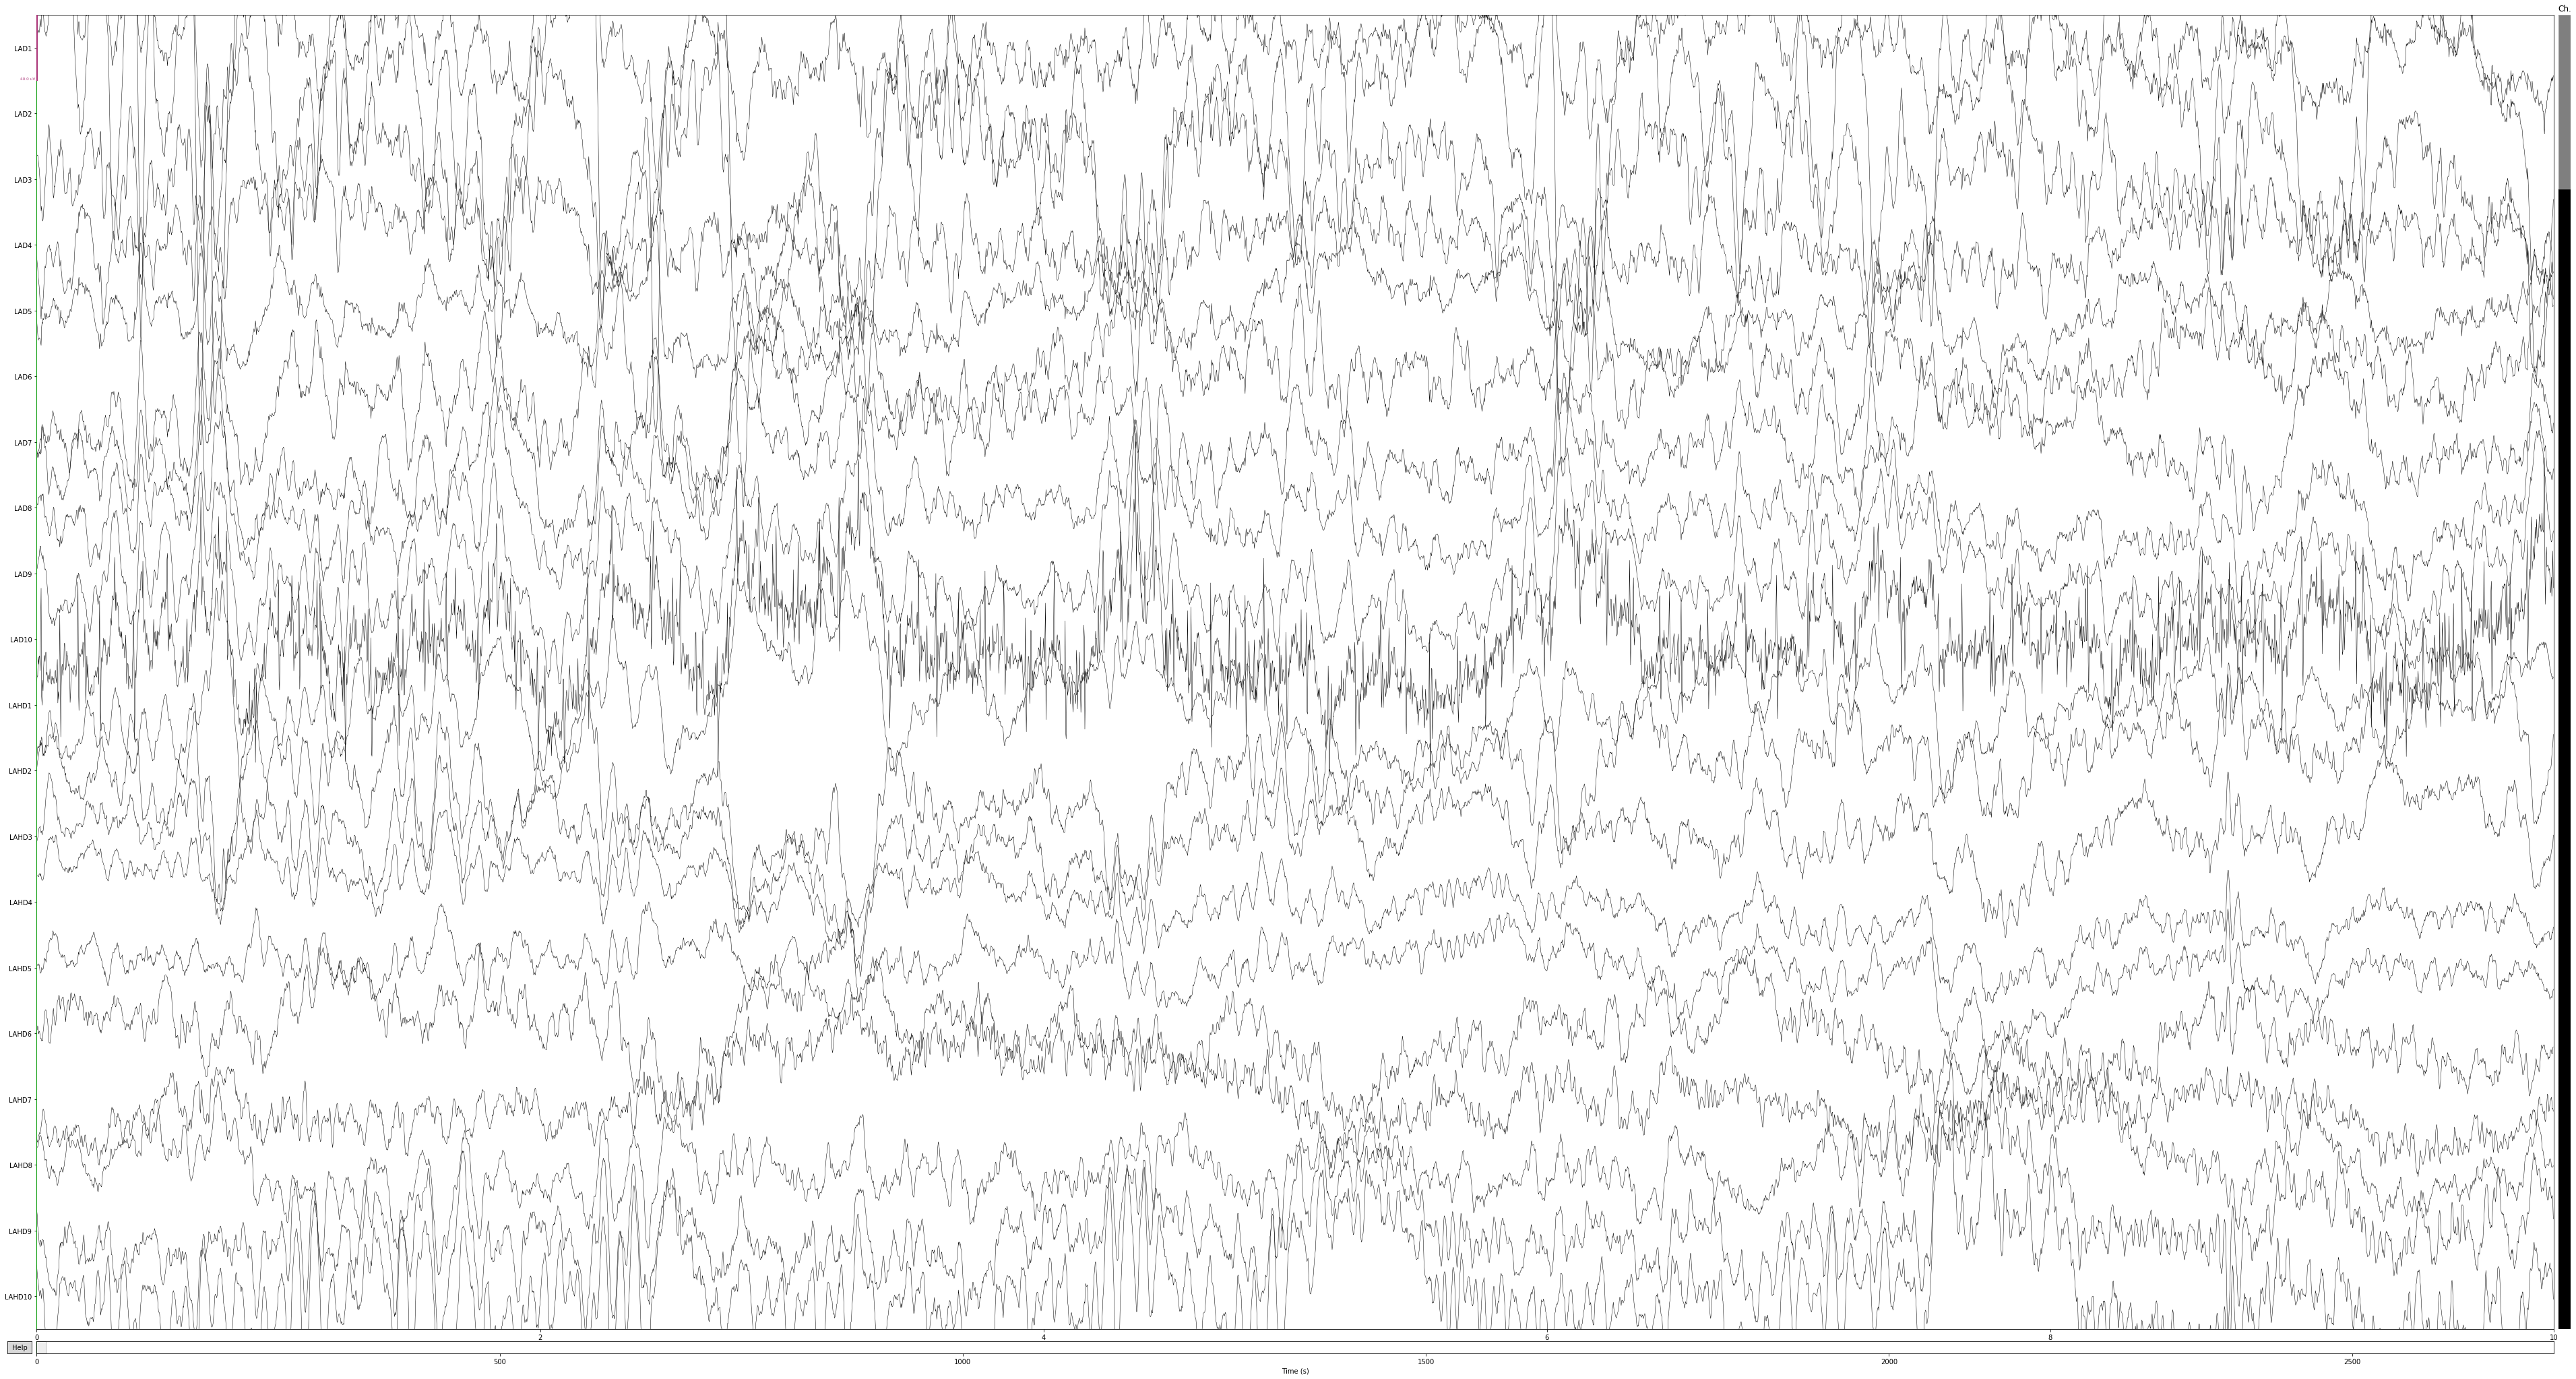

In [13]:
# Check out the results
%matplotlib qt5
plot_raw(raw_21)

In [10]:
# Save the result, for future analysis
raw_2.save("F:\\vmpfc_project\\Summer2019\\ieeg_data\\raw_10_cleaned_v2.fif",overwrite=True)


<ipython-input-10-2c26ead84a36>:2: RuntimeWarning: This filename (F:\vmpfc_project\Summer2019\ieeg_data\raw_10_cleaned_v2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_2.save("F:\\vmpfc_project\\Summer2019\\ieeg_data\\raw_10_cleaned_v2.fif",overwrite=True)
